In [42]:
# import libraries
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [43]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [44]:
# def linear class from mat layers cal
class Linear(torch.nn.Module):
  def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
    factory_kwargs = {'device': device, 'dtype': dtype}
    super(Linear, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = nn.Parameter(torch.empty((out_features, in_features), **factory_kwargs))
    if bias:
        self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self) -> None:
    self.weight = nn.Parameter(torch.rand([self.out_features, self.in_features]))
    if self.bias is not None:
      self.bias = nn.Parameter(torch.rand([self.out_features]))

  def forward(self, input: torch.Tensor) -> torch.Tensor:
    return torch.matmul(input, torch.transpose(self.weight,0,1)) + self.bias

  def extra_repr(self) -> str:
    return 'in_features={}, out_features={}, bias={}'.format(
        self.in_features, self.out_features, self.bias is not None
      )
  

In [45]:
# def BTU func to round out cal
class BTU(torch.nn.Module):
  def __init__(self, T=0.2, inplace: bool = False):
      super(BTU, self).__init__()
      self.T = T

  def forward(self, input: torch.Tensor) -> torch.Tensor:
      return 1 / (1 + torch.exp(-input/self.T))

In [46]:
# def constants for trials
dim = 2
out_dim = 1
num_epocs = 40000
# def trial variable
num_hidden_options = [2, 4]
l_rate_options = [0.01, 0.1]
bypass_options = [False, True]
# create train data and target

# set train data
x_train = torch.tensor([[1, 0.1], [1, 0.9], [0.9, 0.9], [0.1, 0.9]], requires_grad=True, dtype=torch.float32)
t_train = torch.tensor([[1], [0], [0], [1]], dtype=torch.float32)
x_table = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], requires_grad=True, dtype=torch.float32)
t_table = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)
# set validation data
x_validation = torch.concat((x_train, x_table),dim = 0)
t_validation = torch.concat((t_train, t_table), dim = 0)

# def network0
class XOR_Net_Model(nn.Module):
  def __init__(self, dim, num_hidden, bypass=True):
    super().__init__()
    self.bypass = bypass
    self.hidden = Linear(dim, num_hidden)
    if self.bypass:
      self.output = Linear(num_hidden + dim, out_dim)
    else:
      self.output = Linear(num_hidden, out_dim)
    self.BTU = BTU(0.5)
    self.y1 = 0

  def forward(self, input):
    z1 = self.hidden(input)
    self.y1 = self.BTU(z1)
    if self.bypass:
      y1_concat = torch.cat((input, self.y1), 1)
      z2 = self.output(y1_concat)
    else:
      z2 = self.output(self.y1)
    return self.BTU(z2)

  def show_net_data(self):
    print("\n---------------Model parameters---------------:")
    print("\nhidden layer weights:")
    print(self.hidden.weight)
    print("\nhidden layer baises:")
    print(self.hidden.bias)
    print("\noutput layer weights:")
    print(self.output.weight)
    print("\noutput layer baises:")
    print(self.output.bias)


In [47]:
def Loss(out, t_train):
  return -torch.sum(t_train * torch.log(out) + (1.0 - t_train) * torch.log(1.0 - out))  # Cross Entropy loss function


In [48]:
# def train func
def train(model, x_train, t_train, optimizer):
  y_pred = model(x_train)
  loss = Loss(y_pred, t_train)
  # zero gradients berfore running the backward pass
  optimizer.zero_grad()
  # backward pass to compute the gradient of loss
  # backprop + accumulate 
  loss.backward()
  # update params
  optimizer.step()
  return loss

In [49]:
# define test step operation:
def test(model, x_test, t_test):
  loss = Loss(model(x_test), t_test)
  return loss

In [50]:
# run for each possible trial values combinations (8 total diffent modle and each modle run 10 times)
model_count = 0
model_epochs_mean =[]
model_epochs_std =[]
run_number = 1
for l_rate in l_rate_options:
  for num_hidden in num_hidden_options:
    for bypass in bypass_options:
      model_count += 1
      print("--------------------------------------------------\n--------------------MODEL NO. "+ str(model_count) +"-------------------\n--------------------------------------------------")
      print("Model values: l_rate = "+ str(l_rate) +", num_hidden = "+ str(num_hidden) +", bypass= "+ str(bypass))
      success_cout = 0
      epochs_count = []
      train_losses_count = []
      validation_losses_count = []
      flag_not_10 = True
      run_number = 1
      while flag_not_10:
        print("------------------run No."+ str(run_number) +"--------------------")
        run_number += 1
        # create model and show initial values
        model = XOR_Net_Model(dim, num_hidden, bypass)
        model.show_net_data()
        # create methon for training
        optimizer = torch.optim.SGD(model.parameters(), lr=l_rate)
        # create list for keeping track of train loss values
        latest_v_lost = []
        # for each specific modle run trial.
        print("\n----------Epochs----------")
        for i in range(num_epocs): 
          # train the model and get back the current loss value
          train_loss = train(model, x_train, t_train, optimizer)
          train_losses_count.append(train_loss)
          # Evaluate test accuracy
          validation_loss = test(model, x_validation, t_validation)
          validation_losses_count.append(validation_loss)
          latest_v_lost.append(train_loss)
          if len(latest_v_lost) > 10:
            latest_v_lost.pop(0)
          # print res once between 10000 runs
          if i % 10000 == 0:
            print("\nEpoch: %s, loss: %s" % (i, validation_loss))
            print("model output: ")
            print(model(x_train))
          # keep track of the last 10 loss values
          # stop procces condition, success
          if len(latest_v_lost) > 2 and abs(latest_v_lost[0] - latest_v_lost[-1]) <  0.0001 and train_loss < 0.2:
            success_cout += 1
            if success_cout == 10:
              flag_not_10 = False
            epochs_count.append(i)
            train_losses_count.append(train_loss)
            print("Success....... stoped at epocch number " + str(i))
            break
          # anunoce failure
          if i == num_epocs-1:
            print("Failure.......")

      print("succesful run so far: " + str(success_cout))

  
      # convert list of tensors to match mean,sdtq inputs
      epochs_count = torch.FloatTensor(epochs_count)
      train_losses_count = torch.FloatTensor(train_losses_count)
      validation_losses_count = torch.FloatTensor(validation_losses_count)
      #cal means
      epochs_mean = torch.mean(epochs_count)
      model_epochs_mean.append(epochs_mean)
      train_losses_mean = torch.mean(train_losses_count)
      validation_losses_mean = torch.mean(validation_losses_count)
      # cal stdv's
      epochs_stdv = torch.std(epochs_count)
      model_epochs_std.append(epochs_stdv)
      train_losses_stdv = torch.std(train_losses_count)
      validation_losses_stdv = torch.std(validation_losses_count)

      print("*** Successful runs  = " + str(success_cout) + " ***")
      print("*** Failed runs  = " + str(10 - success_cout) + " ***")
      print("*** Epochs for successful train runs:  Avg  = " + str(epochs_mean) + ", Stdv = " + str(epochs_stdv) +" ***")
      print("*** Train loss for successful train runs:  Avg  = " + str(train_losses_mean) + ", Stdv = " + str(train_losses_stdv) +" ***")
      print("*** validation loss for successful train runs:  Avg  = " + str(validation_losses_mean) + ", Stdv = " + str(validation_losses_stdv) +" ***")





--------------------------------------------------
--------------------MODEL NO. 1-------------------
--------------------------------------------------
Model values: l_rate = 0.01, num_hidden = 2, bypass= False
------------------run No.1--------------------

---------------Model parameters---------------:

hidden layer weights:
Parameter containing:
tensor([[0.3384, 0.8548],
        [0.0118, 0.4950]], requires_grad=True)

hidden layer baises:
Parameter containing:
tensor([0.6657, 0.0297], requires_grad=True)

output layer weights:
Parameter containing:
tensor([[0.4473, 0.2126]], requires_grad=True)

output layer baises:
Parameter containing:
tensor([0.8798], requires_grad=True)

----------Epochs----------

Epoch: 0, loss: tensor(11.3433, grad_fn=<NegBackward0>)
model output: 
tensor([[0.9328],
        [0.9404],
        [0.9403],
        [0.9393]], grad_fn=<MulBackward0>)
Success....... stoped at epocch number 4795
------------------run No.2--------------------

---------------Model pa

In [51]:
# the 9th model
print("--------------------------------------------------\n--------------------MODEL NO.9-------------------\n--------------------------------------------------")
print("Model values: l_rate = 0.01, num_hidden = 1, bypass= True")
success_cout = 0
epochs_count = []
train_losses_count = []
validation_losses_count = []
flag_not_10 = True
while flag_not_10:
  print("------------------run No."+ str(i+1) +"--------------------")
  # create model and show initial values
  model = XOR_Net_Model(dim, 1, True)
  model.show_net_data()
  # create methon for training
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  # create list for keeping track of train loss values
  latest_v_lost = []
  # for each specific modle run trial.
  print("\n----------Epochs----------")
  for i in range(num_epocs): 
    # train the model and get back the current loss value
    train_loss = train(model, x_train, t_train, optimizer)
    train_losses_count.append(train_loss)
    # print res once between 1000 runs
    if i % 1000 == 0:
      print("\nEpoch: %s, loss: %s" % (i, train_loss))
      print("model output: ")
      print(model(x_train))
      print("---------------------")
      print("Neuron inputs: ")
      print(x_train)
      print("Neuron outputs: ")
      print(model.y1)
      print("---------------------")
      # after a few runs it seems that the Neuron sometimes acts like an OR Gate and sometimes as XOR Gate

      # Evaluate test accuracy
    validation_loss = test(model, x_validation, t_validation)
    validation_losses_count.append(validation_loss)
  
    # keep track of the last 10 loss values
    latest_v_lost.append(train_loss)
    if len(latest_v_lost) > 10:
      latest_v_lost.pop(0)
    # stop procces condition, success
    if len(latest_v_lost) > 2 and abs(latest_v_lost[0] - latest_v_lost[-1]) <  0.0001 and train_loss < 0.2:
      success_cout += 1
      if success_cout == 10:
        flag_not_10 = False
      epochs_count.append(i)
      train_losses_count.append(train_loss)
      print("Success....... stoped at epocch number " + str(i))
      break
    # anunoce failure
    if i == num_epocs-1:
      print("Failure.......")



# convert list of tensors to match mean,sdtq inputs
epochs_count = torch.FloatTensor(epochs_count)
train_losses_count = torch.FloatTensor(train_losses_count)
validation_losses_count = torch.FloatTensor(validation_losses_count)
#cal means
epochs_mean = torch.mean(epochs_count)
model_epochs_mean.append(epochs_mean)
train_losses_mean = torch.mean(train_losses_count)
validation_losses_mean = torch.mean(validation_losses_count)
# cal stdv's
epochs_stdv = torch.std(epochs_count)
model_epochs_std.append(epochs_stdv)
train_losses_stdv = torch.std(train_losses_count)
validation_losses_stdv = torch.std(validation_losses_count)

print("*** Successful runs  = " + str(success_cout) + " ***")
print("*** Failed runs  = " + str(10 - success_cout) + " ***")
print("*** Epochs for successful train runs:  Avg  = " + str(epochs_mean) + ", Stdv = " + str(epochs_stdv) +" ***")
print("*** Train loss for successful train runs:  Avg  = " + str(train_losses_mean) + ", Stdv = " + str(train_losses_stdv) +" ***")
print("*** validation loss for successful train runs:  Avg  = " + str(validation_losses_mean) + ", Stdv = " + str(validation_losses_stdv) +" ***")


--------------------------------------------------
--------------------MODEL NO.9-------------------
--------------------------------------------------
Model values: l_rate = 0.01, num_hidden = 1, bypass= True
------------------run No.1957--------------------

---------------Model parameters---------------:

hidden layer weights:
Parameter containing:
tensor([[0.7050, 0.2017]], requires_grad=True)

hidden layer baises:
Parameter containing:
tensor([0.4810], requires_grad=True)

output layer weights:
Parameter containing:
tensor([[0.7444, 0.5161, 0.2459]], requires_grad=True)

output layer baises:
Parameter containing:
tensor([0.8852], requires_grad=True)

----------Epochs----------

Epoch: 0, loss: tensor(9.2272, grad_fn=<NegBackward0>)
model output: 
tensor([[0.9731],
        [0.9875],
        [0.9856],
        [0.9544]], grad_fn=<MulBackward0>)
---------------------
Neuron inputs: 
tensor([[1.0000, 0.1000],
        [1.0000, 0.9000],
        [0.9000, 0.9000],
        [0.1000, 0.9000]]

f) after a few runs it seems that the Neuron is acting mostly like an OR Gate

g)


In [52]:
models_hidden_layers = [2, 2, 4, 4, 2, 2, 4, 4, 1]
print("models_hidden_layers: ")
print(models_hidden_layers)
print("model_epochs_mean: ")
print(model_epochs_mean)

models_hidden_layers: 
[2, 2, 4, 4, 2, 2, 4, 4, 1]
model_epochs_mean: 
[tensor(5118.2002), tensor(6015.2998), tensor(4686.), tensor(5757.1001), tensor(1176.7000), tensor(1496.), tensor(1164.2000), tensor(1408.8000), tensor(6624.3999)]


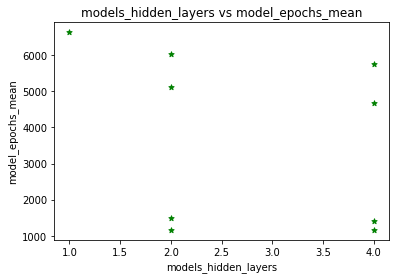

In [53]:
# plotting the points 
plt.scatter(models_hidden_layers ,model_epochs_mean, label= "stars", color= "green", marker= "*", s=30)
plt.xlabel('models_hidden_layers')
plt.ylabel('model_epochs_mean')
plt.title('models_hidden_layers vs model_epochs_mean')
plt.show()

1. the means results suggests that the bigger the hidden layer size is the smaller avg of epochs per model

In [54]:
models_bypass = [False, True, False, True, False, True, False, True, True]
print("models_bypass: ")
print(models_bypass)
print("model_epochs_mean: ")
print(model_epochs_mean)

models_bypass: 
[False, True, False, True, False, True, False, True, True]
model_epochs_mean: 
[tensor(5118.2002), tensor(6015.2998), tensor(4686.), tensor(5757.1001), tensor(1176.7000), tensor(1496.), tensor(1164.2000), tensor(1408.8000), tensor(6624.3999)]


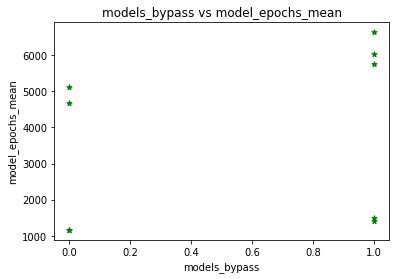

In [55]:
# plotting the points 
plt.scatter(models_bypass ,model_epochs_mean, label= "stars", color= "green", marker= "*", s=30)
plt.xlabel('models_bypass')
plt.ylabel('model_epochs_mean')
plt.title('models_bypass vs model_epochs_mean')
plt.show()

2. models with with bypass on avg have a greater mean of epochs than the same models without the bypass

In [56]:
models_l_rates = [0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1,  0.01,]
print("models_l_rates: ")
print(models_l_rates)
print("model_epochs_std: ")
print(model_epochs_std)

models_l_rates: 
[0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.01]
model_epochs_std: 
[tensor(398.4450), tensor(1176.5719), tensor(387.9247), tensor(785.5455), tensor(101.8900), tensor(403.0980), tensor(79.7229), tensor(327.5603), tensor(839.2326)]


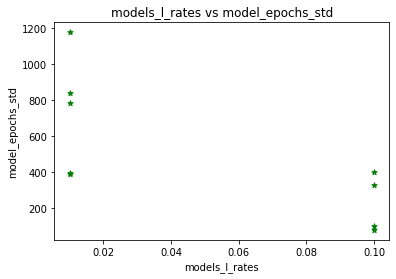

In [57]:
# plotting the points 
plt.scatter(models_l_rates ,model_epochs_std, label= "stars", color= "green", marker= "*", s=30)
plt.xlabel('models_l_rates')
plt.ylabel('model_epochs_std')
plt.title('models_l_rates vs model_epochs_std')
plt.show()

3. the model results suggest that the lower the Learing rate is the greater the avg standart diviation

In [58]:
print("model output: ")
print(model(x_train))
print("---------------------")
print("Neuron inputs: ")
print(x_train)
print("Neuron outputs: ")
print(model.y1)
print("---------------------")

model output: 
tensor([[0.9796],
        [0.0095],
        [0.0243],
        [0.9796]], grad_fn=<MulBackward0>)
---------------------
Neuron inputs: 
tensor([[1.0000, 0.1000],
        [1.0000, 0.9000],
        [0.9000, 0.9000],
        [0.1000, 0.9000]], requires_grad=True)
Neuron outputs: 
tensor([[0.9869],
        [0.9974],
        [0.9970],
        [0.9903]], grad_fn=<MulBackward0>)
---------------------


4. as we can see in this case, after training the nueron it self is resembling  as a Xor Gate 